# Convolutional Neural Networks

In [1]:
import numpy as np

## Testando o CUDA

In [2]:
import torch

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA nao funcionando. Treinamento na CPU ...')
else:
    print('CUDA esta disponivel! Treinando na GPU ...')

CUDA esta disponivel! Treinando na GPU ...


## Carregando os dados e aumentando os dados

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
# numero de subprocessos usados para carregar os dados
num_workers = 0
# quantas amostras serao carregadas para cada batch
batch_size = 20
# porcentagem dos conjuntotes de treinamento e validacao
valid_size = 0.2

# converte os dados para um torch.FloatTensor normalizado
transform = transforms.Compose([
    # transforms.Pad(padding=10), # preenche as bordas da imagem com algum valor
    # transforms.Resize(size=50), # redimenciona a imagem
    # transforms.CenterCrop(size=50), # corta a imagem no centro
    # transforms.Grayscale(), # converte a imagem em escala de sinza
    # transforms.ColorJitter(brightness=.5, contrast=0, saturation=0, hue=.3), # transforma os parâmetros da imagem aleatóriamente
    # transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1,5)), # ofusca a imagem
    # transforms.RandomPerspective(distortion_scale=0.6, p=0.3), # transforma a perspectiva da imagem aleatóriamente
    # transforms.RandomAffine(10), # altera a perspectiva da imagem de maneira aleatória
    # transforms.RandomInvert(p=0.3), # inverte as cores aleatóriamente
    # transforms.RandomPosterize(bits=2, p=0.6), # reduz o número de bits em cada canal de cor
    transforms.RandomHorizontalFlip(), # inverte e rotaciona aleatoriamente
    # transforms.RandomVerticalFlip(), # rotaciona a imagem verticalmente
    transforms.RandomRotation(10), # rotaciona a imagem em um ângulo aleatório
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# escolhe os dados de treino e teste
train_data = datasets.CIFAR10('~/data/pytorch/CIFAR10_data/', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('~/data/pytorch/CIFAR10_data/', train=False,
                             download=True, transform=transform)

# obtem os indices de treino que serao usados para validacao
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define os samplers para extrair os batches de treinamento e validacao
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepara os data loaders (combina o dataset e o sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# especifica a classe das imagens
classes = ['aviao', 'automovel', 'passaro', 'gato', 'veado',
           'cachorro', 'sapo', 'cavalo', 'navio', 'caminhao']

Files already downloaded and verified
Files already downloaded and verified


### Visualizando o batch de treinamento

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# funcao auxiliar para desnormalizar e mostrar a imagem
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # converte o tensor para imagem

/tmp/ipykernel_28362/245861161.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


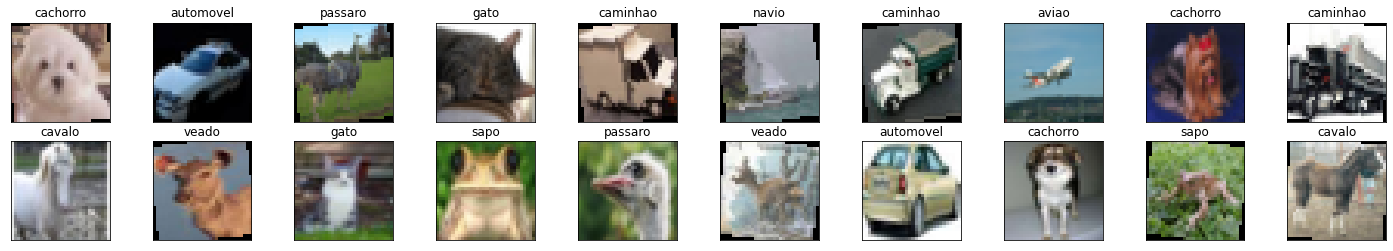

In [8]:
# obtem um batch de amostras de treinamento
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # converte as imagens para formato numpy para apresentar

# plota as imagens no batch, junto com os respectivos rotulos
fig = plt.figure(figsize=(25, 4))
# mostra 20 imagens
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Visualizando as imagens com maiores detalhes

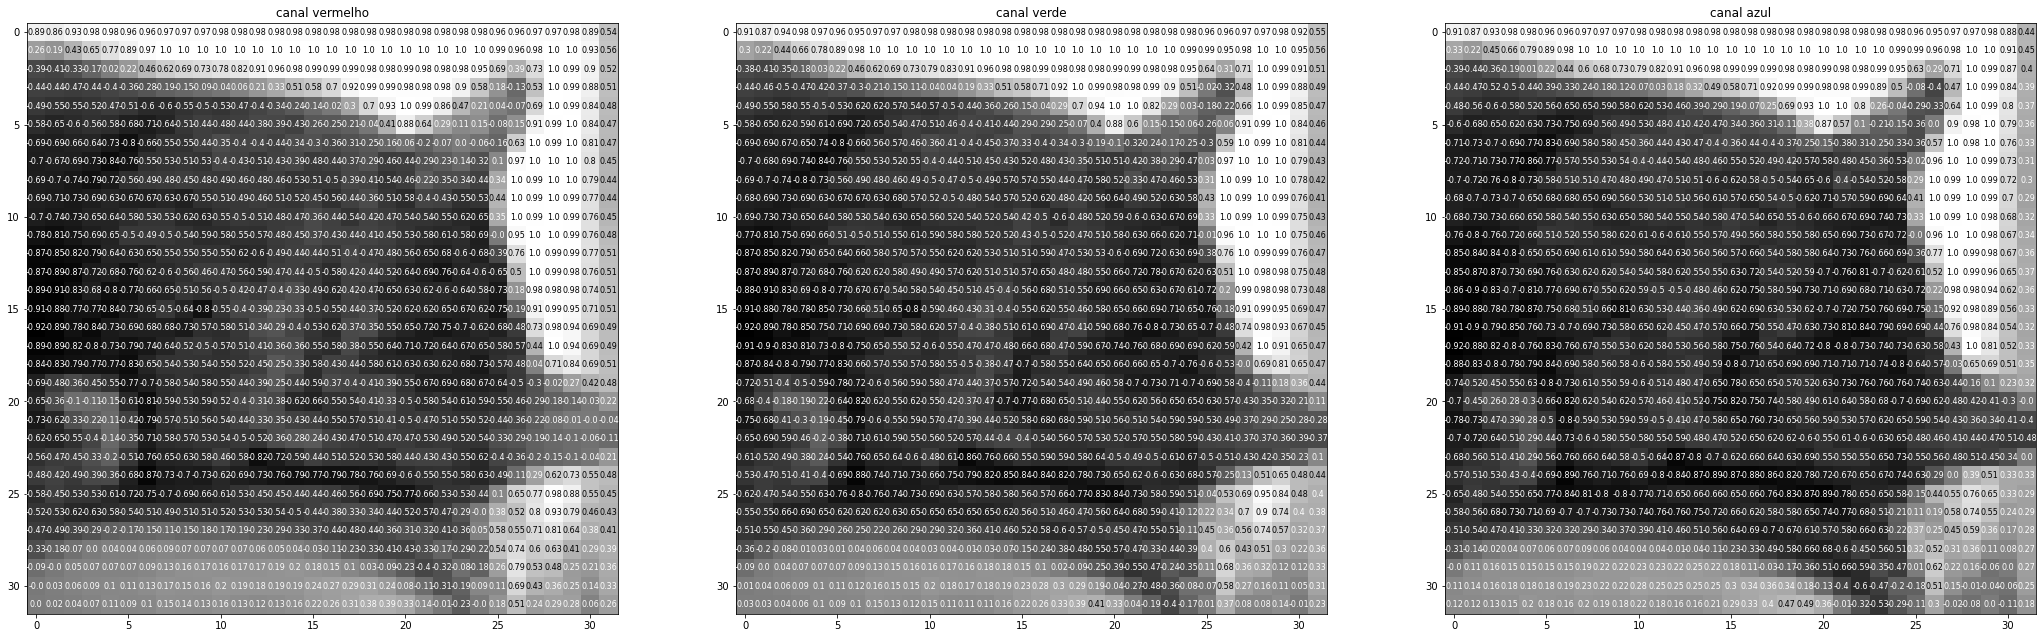

In [9]:
rgb_img = np.squeeze(images[3])
channels = ['canal vermelho', 'canal verde', 'canal azul']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## Definindo a arquitetura da rede

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
# Definindo nossa arquitetura
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Camada convolucional (enxerga um tensor representando uma imagem de dimensao 32x32x3)
        # primeiro parametro e o numero de canais de entrada (3 pq e RGB), segundo e o numero de canais de saida (16)
        # terceiro e o tamanho do kernel (filtro de 3x3) e o padding e uma moldura para evitar que a imagem seja redimensionada.
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # Camada convolucional (enxerga um tensor de  16x16x16 - 16 canais, dimensionalidade reduzida de 32x32 pela camada de MaxPool)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # Camada convolucional (enxerga um tensor de  8x8x32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # camada max pooling
        self.pool = nn.MaxPool2d(2, 2)
        # camada linear (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # camada linear (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # camada dropout (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # adiciona uma sequencia de convolucoes e maxpooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # achata x, transformando em um vetor
        x = x.view(-1, 64 * 4 * 4)
        # adiciona a camada dropout
        x = self.dropout(x)
        # adiciona a primeira camada escondida, com ativacao relu
        x = F.relu(self.fc1(x))
        # adiciona uma camada dropout
        x = self.dropout(x)
        # adiciona segunda camada escondida, com ativacao relu
        x = self.fc2(x)
        return x

# cria uma CNN completa
model = Net()
print(model)

# move os tensores pra GPU, se o CUDA estiver disponivel
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


Alguma transformação está almentando o número de "baches" na partição de teste

## Definindo a função de custo

In [12]:
import torch.optim as optim

In [13]:
# especificamos como funcao de custo a funncao categorical cross-entropy
criterion = nn.CrossEntropyLoss()

# e como funcao de otimizacao o gradiente descendente estocastico
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Treinando a rede

In [14]:
model.train()
for batch_idx, (data, target) in enumerate(train_loader):
    # move os tensores pra GPU se o CUDA estiver disponivel
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()


In [15]:
model(data).size()

/home/luis/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([20, 10])

In [16]:
model(data).shape

torch.Size([20, 10])

In [17]:
# numero de epocas de treinamento
n_epochs = 12

valid_loss_min = np.Inf # mantem registro do custo minimo de validacao

for epoch in range(1, n_epochs+1):

    # mantem registro dos custos de treinamento e validacao
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # treina o modelo #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move os tensores pra GPU se o CUDA estiver disponivel
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # limpa os gradientes de todas as variaveis otimizadas
        optimizer.zero_grad()
        # passo forward: computa as saidas do modelo
        output = model(data)
        # calcula o custo por batch
        loss = criterion(output, target)
        # passo backward: computa o gradiente do custo em respeito aos parametros do modelo
        loss.backward()
        # executa um unico passo de otimizacao (atualizacao dos parametros)
        optimizer.step()
        # atualiza o custo de trein
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # valida o modelo #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move os tensores para a GPU se o CUDA estiver disponivel
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # passo forward: computa as saidas do modelo
        output = model(data)
        # calcula o custo por batch
        loss = criterion(output, target)
        # atualiza o custo de validacao
        valid_loss += loss.item()*data.size(0)
    
    # calcula a media dos custos
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # imprime  as estatisticas de treino e validacao 
    print('Epoca: {} \tCusto de treinamento: {:.6f} \tCusto de validacao: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # salva o modelo se o custo de validacao diminuir
    if valid_loss <= valid_loss_min:
        print('Reducao do custo de validacao ({:.6f} --> {:.6f}).  Salvando o modelo ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoca: 1 	Custo de treinamento: 2.070321 	Custo de validacao: 1.782245
Reducao do custo de validacao (inf --> 1.782245).  Salvando o modelo ...
Epoca: 2 	Custo de treinamento: 1.670658 	Custo de validacao: 1.538429
Reducao do custo de validacao (1.782245 --> 1.538429).  Salvando o modelo ...
Epoca: 3 	Custo de treinamento: 1.496542 	Custo de validacao: 1.376484
Reducao do custo de validacao (1.538429 --> 1.376484).  Salvando o modelo ...
Epoca: 4 	Custo de treinamento: 1.398038 	Custo de validacao: 1.324236
Reducao do custo de validacao (1.376484 --> 1.324236).  Salvando o modelo ...
Epoca: 5 	Custo de treinamento: 1.315505 	Custo de validacao: 1.241864
Reducao do custo de validacao (1.324236 --> 1.241864).  Salvando o modelo ...
Epoca: 6 	Custo de treinamento: 1.249199 	Custo de validacao: 1.140652
Reducao do custo de validacao (1.241864 --> 1.140652).  Salvando o modelo ...
Epoca: 7 	Custo de treinamento: 1.192762 	Custo de validacao: 1.115922
Reducao do custo de validacao (1.140652 

## Carregando o modelo com menor custo de validação

In [18]:
model.load_state_dict(torch.load('model_augmented.pt'))

<All keys matched successfully>

## Testando a rede treinada

In [19]:
# registra o custo de teste
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# itera sobre os dados de teste
for batch_idx, (data, target) in enumerate(test_loader):
    # move os tensores pra GPU, se disponivel
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # passo forward: computa as saidas do modelo
    output = model(data)
    # computa o custo do batch
    loss = criterion(output, target)
    # atualiza o custo de teste
    test_loss += loss.item()*data.size(0)
    # converte as probabilidades para a classe predita
    _, pred = torch.max(output, 1)    
    # compara as predicoes com os rotulos reais
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # computa a acuracia para cada classe
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# media de custo de teste
test_loss = test_loss/len(test_loader.dataset)
print('Custo de teste: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Acuracia de teste de %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Acuracia de teste de %5s: N/A (nenhuma amostra vista no treinamento)' % (classes[i]))

print('\nAcuracia de teste (Geral): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Custo de teste: 0.933775

Acuracia de teste de aviao: 73% (732/1000)
Acuracia de teste de automovel: 79% (791/1000)
Acuracia de teste de passaro: 61% (613/1000)
Acuracia de teste de  gato: 34% (349/1000)
Acuracia de teste de veado: 64% (648/1000)
Acuracia de teste de cachorro: 55% (551/1000)
Acuracia de teste de  sapo: 83% (838/1000)
Acuracia de teste de cavalo: 71% (710/1000)
Acuracia de teste de navio: 78% (781/1000)
Acuracia de teste de caminhao: 73% (738/1000)

Acuracia de teste (Geral): 67% (6751/10000)


## Vizualizando os resultados de teste

/tmp/ipykernel_28362/247088312.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


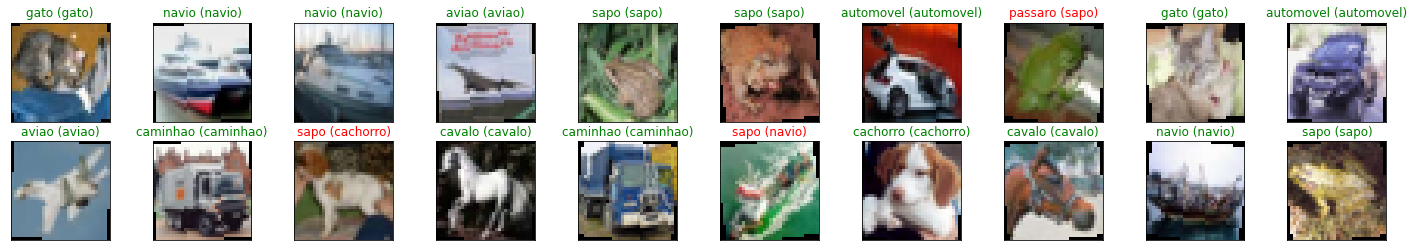

In [20]:
# obtendo um batch de amostras de teste
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# movendo as entradas para GPU
if train_on_gpu:
    images = images.cuda()

# obtendo as saidas
output = model(images)
# convertendo as probabilidades em classes
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plotando as imagens do batch junto com a classe predita e real
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx].to('cpu'))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))